In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(13)
from tqdm.auto import tqdm

import rdkit
print(rdkit.__version__)
from rdkit import Chem
from rdkit.Chem import AllChem 
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
from rdkit.ML.Scoring.Scoring import CalcBEDROC
import joblib

import sklearn
from sklearn.ensemble import RandomForestClassifier

print(sklearn.__version__)

from imblearn.over_sampling import SMOTE, SMOTENC

/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2021.03.2
1.3.2


In [2]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
# Function to calculate TPR at specific FPR (e.g., 1%)
def tpr_at_fpr(fpr_array, tpr_array, target_fpr=0.01):
    interp_tpr = interp1d(fpr_array, tpr_array)
    return interp_tpr(target_fpr)

In [3]:
subset1 = pd.read_csv('./datasets/3_train_test_split/pubchem_train_ECFP4_rdkit2d.csv')
subset2 = pd.read_csv('./datasets/3_train_test_split/pubchem_test_ECFP4_rdkit2d.csv')

In [4]:
print(len(subset1), len(subset2))

1878 470


## prepare similarity based splitting for cross validation

In [5]:
#meeded in cluter with butina function
def tanimoto_distance_matrix(fp_list):
    """
    Calculate distance matrix for fingerprint list.
    Copy pasted form Reference (see top of the notebook).
    """
    dissimilarity_matrix = []
    for i in tqdm(range(1, len(fp_list))):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [6]:
#cluster with butina

def cluster_fingerprints(fp_list, cutoff=0.7):
    """
    Cluster fingerprints using Butina:
    given the input distance matrix cluster together all the
    molecules with a distance <= cutoff.
    e.g.: if cutoff == 0.3 the molecules with tanimoto >= 0.7
    will be clustered together.

    Returns a list of tuples where each tuple is a cluster
    and each value in the tuple correspond to the fingerprint
    index in the fingerprints list.

    Copy pasted from the Reference (see top of the notebook)
    """
    # Calculate Tanimoto distance matrix
    print("Computing distance matrix . . .")
    distance_matrix = tanimoto_distance_matrix(fp_list)
    # Cluster the data with the implemented Butina algorithm.
    print("Computing clusters . . .")
    clusters = Butina.ClusterData(distance_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True) # Sort the list of clusters in descending order.
    print("Clusters computed!")
    return clusters

In [7]:
smiles = subset1['preprocessedSmiles']
# Get only the values from the series.
smiles_array = smiles.values


In [8]:
smiles_array

array(['C#CC(C)(C)NC(=O)c1cc(Cl)cc(Cl)c1',
       'CC[N+](CC)(CC)CCC(O)(c1ccccc1)C1CCCCC1',
       'CC(CN1c2ccccc2Sc2ccccc21)N(C)C', ...,
       'CC1C(=O)OC2CCN3CC=C(COC(=O)C(C)(O)C1(C)O)C23',
       'Cc1ccccc1-n1c(C)nc2ccccc2c1=O',
       'C=Cc1c(C)c2[nH]c1=Cc1[nH]c(c(=CC)c1C)=Cc1[nH]c(c(C(=O)O)c1C)C(CC(=O)O)c1[nH]c(c(C)c1CCC(=O)O)C=2'],
      dtype=object)

In [9]:
print("# of unique smiles:", len(smiles_array))
fingerprints_list = []
for smi in tqdm(smiles):
    mol = Chem.MolFromSmiles(smi) # get mol object
    fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    fingerprints_list.append(fps)


# of unique smiles: 1878


100%|██████████| 1878/1878 [00:00<00:00, 6583.96it/s]


In [10]:
clusters = cluster_fingerprints(fingerprints_list)

Computing distance matrix . . .


100%|██████████| 1877/1877 [00:00<00:00, 6594.80it/s] 


Computing clusters . . .
Clusters computed!


In [11]:
len(clusters)

651

In [12]:
# Specify parameters
folds = 5 # number of splits you need

In [13]:
def cross_validation_splits(smiles, clusters, folds):
    """
    Group smiles strings into n = folds datasets.
    """
    # Number of compounds you want in each split.
    # Assume cv split so same number of compounds for each splits.
    splits_size = np.floor(len(smiles)/folds)
    
    random.shuffle(clusters) # shuffle the clusters

    splits = {key: [] for key in range(folds)}
    key = 0
    for clu in tqdm(clusters):
        # Check that the lenght of the split does not exceed the lenght of the split.
        # This ensure that all the splits will have almost the same lenght.
        if len(splits[key]) <= splits_size:
            splits[key] += list(smiles[list(clu)])
        # If not go to the next split.
        else:
            key += 1
            splits[key] += list(smiles[list(clu)])
    return splits

In [14]:
splits = cross_validation_splits(smiles_array, clusters, folds)

100%|██████████| 651/651 [00:00<00:00, 420787.78it/s]


In [15]:
type(splits)

dict

In [16]:
print(type(splits[0]))

<class 'list'>


In [17]:
type(splits[0][1])

str

In [18]:
len(splits)

5

In [19]:
# Print the lenght of each split.
for idx, val in splits.items():
    print(f"len fold {idx} :", len(val))

len fold 0 : 378
len fold 1 : 376
len fold 2 : 391
len fold 3 : 378
len fold 4 : 355


In [20]:
print(splits.items())

dict_items([(0, ['CN(C)CCC=C1c2ccccc2C(C)(C)c2ccccc21', 'CN(C)CCC=C1c2ccccc2COc2ccccc21', 'CN(C)CCC=C1c2ccccc2COc2ccc(CC(=O)O)cc21', 'CN(C)CCCN1c2ccccc2C(C)(C)c2ccccc21', 'CN(C)CCC=C1c2ccccc2C=Cc2ccccc21', 'CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1', 'CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c3c2OCN4C)CC1', 'NC1CCN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3-c2ccc(F)cc2F)C1', 'COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12', 'CCn1cc(C(=O)O)c(=O)c2cnc(N3CCCC3)nc21', 'O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O', 'COc1c(N2CC3CCCNC3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12', 'NC1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)CC12', 'CC1CCc2cc(F)cc3c(=O)c(C(=O)O)cn1c23', 'CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23', 'CC1COc2c(C3(N)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23', 'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)nc21', 'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCN(C)CC3)cc21', 'CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23', 'CC1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c3c2F)CC(C)N1', 'CC1CN(c2c(F)c(F)c3c(=O)c(C(=O)O)cn(C

In [21]:
def map_func(x):
    for k, v in splits.items():
        if x in v:
            return str(k)


# Create a new column in the dataframe and apply the mapping function to the existing_col column
subset1['cluster_id'] = subset1['preprocessedSmiles'].apply(map_func)

## RDKit 2D models

### cross validation

In [22]:
from sklearn.model_selection import GroupKFold
groups = np.array(subset1['cluster_id'])

In [23]:
sm = SMOTE(random_state = 42)

In [24]:
def roc_cv(X, y, max_features): ## with SMOTE for rdkit2d
    cv = GroupKFold(n_splits=5)
    classifier = RandomForestClassifier(n_estimators=1000, max_features=max_features, 
                                        min_samples_split=2, random_state=42)
                                        #max_features and min_samples_split are actually equal to default
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    BEDROC = []

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
        #add SMOTE to each fold
        
        X_train_sm, y_train_sm = sm.fit_resample(X[train],y[train])
        classifier.fit(X_train_sm, y_train_sm)
        y_prob = classifier.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        
        score = list(zip(y_prob, y[test]))
        score.sort(key=lambda x: x[0], reverse=True)
        bedroc_score = CalcBEDROC(score, 1, 80.5)
        BEDROC.append(bedroc_score)

   
    print(BEDROC)
    mean_bedroc = np.mean(BEDROC)
    std_bedroc = np.std(BEDROC)
    print("BEDROC: {:.3f} +/- {:.3f}".format(mean_bedroc, std_bedroc))

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()
    return mean_bedroc

In [25]:
desc_cols = subset1.iloc[:, 2055:2263] 

In [26]:
desc_cols

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.799684,-0.702503,11.799684,0.298750,0.809002,256.132,245.044,255.021769,84.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.747259,-0.648125,11.747259,0.422332,0.687580,318.525,282.237,318.279141,130.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.450231,0.499271,2.450231,0.499271,0.832154,284.428,264.268,284.134720,104.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.061976,-0.283325,12.061976,0.283325,0.880881,316.426,296.266,316.124549,116.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11.702012,-3.827371,11.702012,0.005974,0.879458,276.745,263.641,276.033541,94.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,13.398429,-1.502123,13.398429,0.354837,0.512793,417.417,398.265,417.121237,156.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1874,10.003023,-0.662199,10.003023,0.053197,0.744293,277.195,259.051,276.079619,96.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1875,12.447149,-2.218514,12.447149,0.022482,0.462275,325.361,302.177,325.152537,128.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1876,12.624911,-0.016296,12.624911,0.016296,0.665121,250.301,236.189,250.110613,94.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def find_best_max_features(X, y, max_features_list):
    
    best_max_features = None
    best_bedroc = -np.inf  # Initialize with a very low value

    for max_features in max_features_list:
        mean_bedroc = roc_cv(X, y, max_features)
        if mean_bedroc > best_bedroc:
            best_bedroc = mean_bedroc
            best_max_features = max_features

    print(f"Best max_features: {best_max_features} with BEDROC: {best_bedroc:.3f}")
    return best_max_features, best_bedroc

In [28]:
X = np.array(desc_cols)
y = np.array(subset1.y_true_label)

In [29]:
max_features_list = [None, 'sqrt', 0.2, 0.4, 0.8]

[0.524585716877295, 0.5032306905192994, 0.7803906041382902, 0.44578516819824787, 0.8069672621498712]
BEDROC: 0.612 +/- 0.151


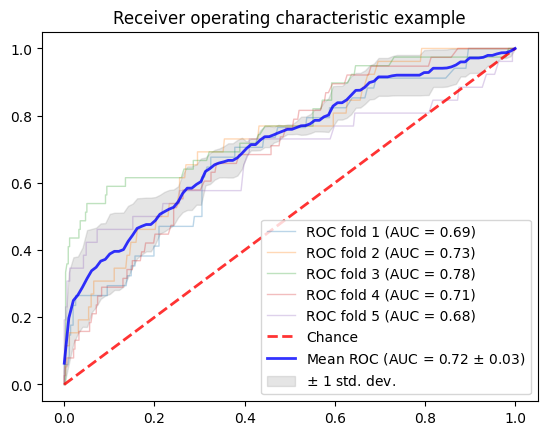

[0.7415142945735459, 0.7503872693754577, 0.8798167817792243, 0.5225267317836366, 0.7445879600012446]
BEDROC: 0.728 +/- 0.115


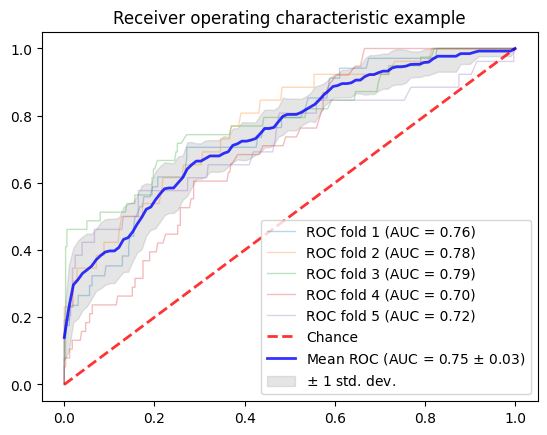

[0.7754172412846466, 0.7019212827906975, 0.8761027864337109, 0.5415079670127829, 0.7462863962103161]
BEDROC: 0.728 +/- 0.110


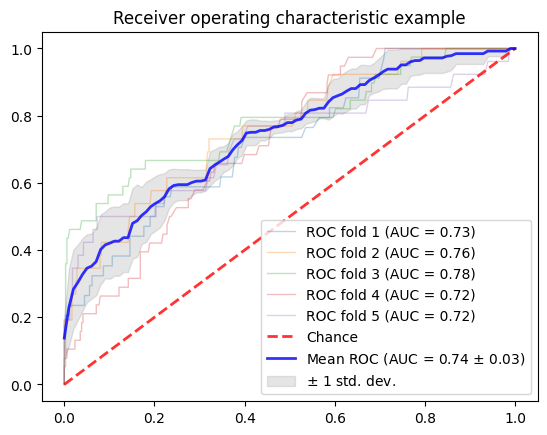

[0.7617321743576866, 0.6737374898488094, 0.8541741630710645, 0.5154669270463099, 0.7393336100991977]
BEDROC: 0.709 +/- 0.113


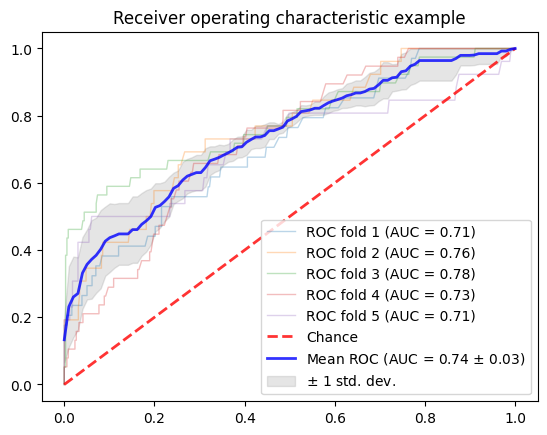

[0.6152477274192988, 0.658981562862302, 0.8207098381311929, 0.45400451109436746, 0.8093310210483172]
BEDROC: 0.672 +/- 0.136


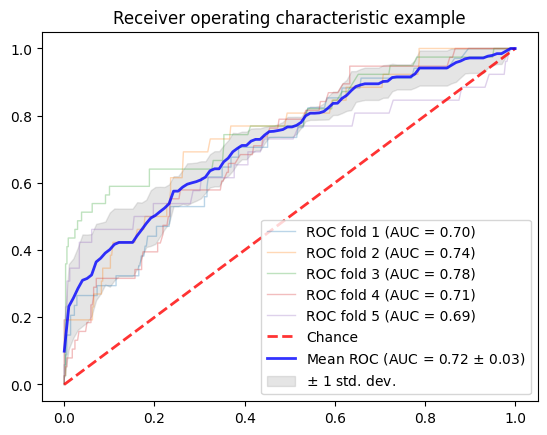

Best max_features: 0.2 with BEDROC: 0.728


In [30]:
best_max_features, best_bedroc = find_best_max_features(X, y, max_features_list)

### combine the folds and train with best hyperparameter

In [31]:
#80% model, with the best hyperparamter
X = np.array(desc_cols)
y = np.array(subset1.y_true_label)
sm = SMOTE(random_state = 42)
X, y = sm.fit_resample(X,y)
model_0 = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(X, y)

In [32]:
# test with 20% test set
desc_cols2 = subset2.iloc[:, 2055:2263] 
X = np.array(desc_cols2)
y = subset2.y_true_label

[(0.921, 1.0), (0.857, 0.0), (0.851, 1.0), (0.707, 0.0), (0.658, 1.0), (0.657, 1.0), (0.65, 0.0), (0.577, 1.0), (0.573, 0.0), (0.534, 1.0), (0.524, 0.0), (0.524, 0.0), (0.518, 0.0), (0.501, 1.0), (0.492, 1.0), (0.485, 0.0), (0.46, 0.0), (0.459, 0.0), (0.458, 1.0), (0.45, 0.0), (0.446, 0.0), (0.44, 0.0), (0.438, 1.0), (0.438, 0.0), (0.433, 0.0), (0.418, 0.0), (0.417, 0.0), (0.414, 0.0), (0.403, 0.0), (0.401, 0.0), (0.399, 0.0), (0.395, 0.0), (0.383, 0.0), (0.38, 0.0), (0.379, 0.0), (0.373, 0.0), (0.366, 1.0), (0.362, 1.0), (0.353, 0.0), (0.341, 0.0), (0.341, 0.0), (0.34, 0.0), (0.339, 0.0), (0.33, 1.0), (0.33, 1.0), (0.329, 0.0), (0.322, 0.0), (0.319, 0.0), (0.313, 0.0), (0.311, 0.0), (0.311, 0.0), (0.31, 1.0), (0.309, 0.0), (0.296, 0.0), (0.294, 0.0), (0.286, 0.0), (0.285, 0.0), (0.269, 1.0), (0.261, 0.0), (0.26, 0.0), (0.259, 0.0), (0.257, 0.0), (0.257, 1.0), (0.256, 0.0), (0.256, 0.0), (0.256, 0.0), (0.256, 1.0), (0.254, 0.0), (0.248, 0.0), (0.248, 0.0), (0.247, 0.0), (0.245, 0.0), (

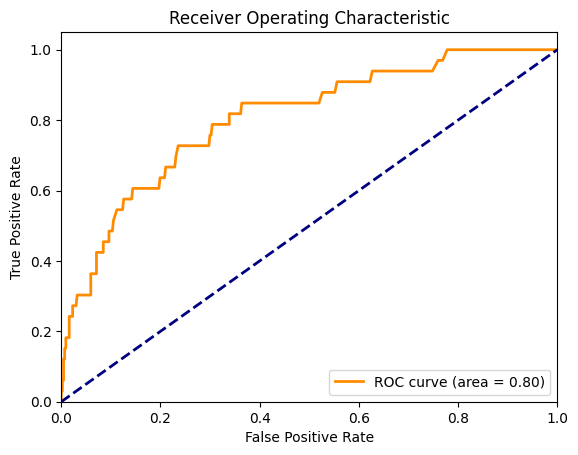

In [33]:
# Predict probabilities for the test data
y_scores = model_0.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
print(score)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [34]:
# combine train and test set and train the final model with full dataset
fullset = pd.concat([subset1, subset2], ignore_index=True)
desc_cols3 = fullset.iloc[:, 2055:2263]
X = np.array(desc_cols3)
y = np.array(fullset.y_true_label)

sm = SMOTE(random_state = 42)
X, y = sm.fit_resample(X,y)

In [35]:
combined_model = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(X, y)
joblib.dump(combined_model, f'./trained_models/pubchem_rdkit2D_fullset.joblib')

['./trained_models/pubchem_rdkit2D_fullset.joblib']

## ECFP4 models

### cross validation

In [36]:
sm = SMOTENC(categorical_features=[0,1], random_state = 42)

In [37]:
def roc_cv_NC(X, y, max_features): ## with SMOTENC for ecfp4
    cv = GroupKFold(n_splits=5)
    classifier = RandomForestClassifier(n_estimators=1000, max_features=max_features, 
                                        min_samples_split=2, random_state=42)
                                        #max_features and min_samples_split are actually equal to default
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    BEDROC = []

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
        #add SMOTE to each fold
        print(y[train])
        X_train_sm, y_train_sm = sm.fit_resample(X[train],y[train])
        classifier.fit(X_train_sm, y_train_sm)
        y_prob = classifier.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        
        score = list(zip(y_prob, y[test]))
        score.sort(key=lambda x: x[0], reverse=True)
        bedroc_score = CalcBEDROC(score, 1, 80.5)
        BEDROC.append(bedroc_score)

   
    print(BEDROC)
    mean_bedroc = np.mean(BEDROC)
    std_bedroc = np.std(BEDROC)
    print("BEDROC: {:.3f} +/- {:.3f}".format(mean_bedroc, std_bedroc))

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()
    return mean_bedroc

In [38]:
def find_best_max_features(X, y, max_features_list):
    
    best_max_features = None
    best_bedroc = -np.inf  # Initialize with a very low value

    for max_features in max_features_list:
        mean_bedroc = roc_cv_NC(X, y, max_features)
        if mean_bedroc > best_bedroc:
            best_bedroc = mean_bedroc
            best_max_features = max_features

    print(f"Best max_features: {best_max_features} with BEDROC: {best_bedroc:.3f}")
    return best_max_features, best_bedroc

In [39]:
morgan2_cols = ['morgan2_b'+str(i) for i in list(range(2048))]


In [40]:
X = np.array(subset1[morgan2_cols])
y = np.array(subset1.y_true_label)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.36706505737772765, 0.08172910604474047, 0.16645949826973166, 0.5041232703530522, 0.1689884279888146]
BEDROC: 0.258 +/- 0.155


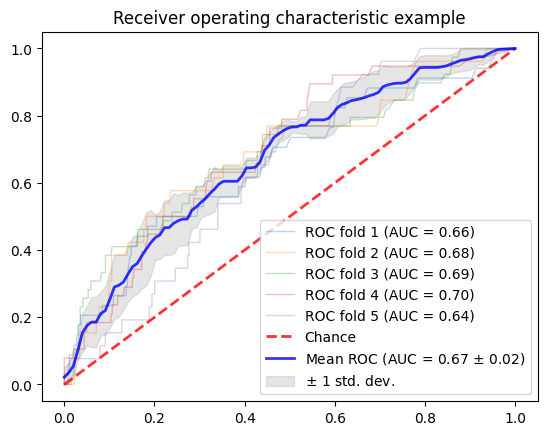

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.23623145173898236, 0.14654954173910598, 0.7064019562859529, 0.26572977079934595, 0.3874263908081763]
BEDROC: 0.348 +/- 0.195


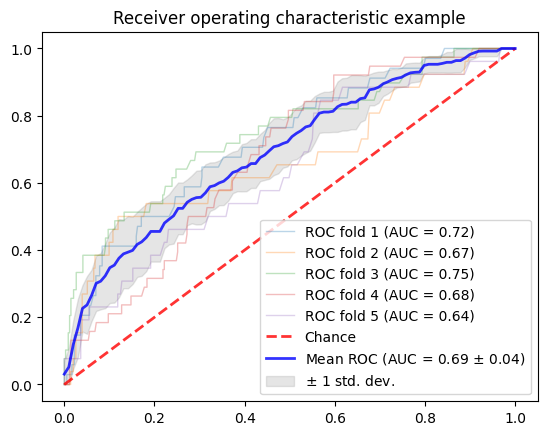

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.29420109089250696, 0.0643463140765257, 0.48526719983766675, 0.27993467789062704, 0.23934251572242785]
BEDROC: 0.273 +/- 0.134


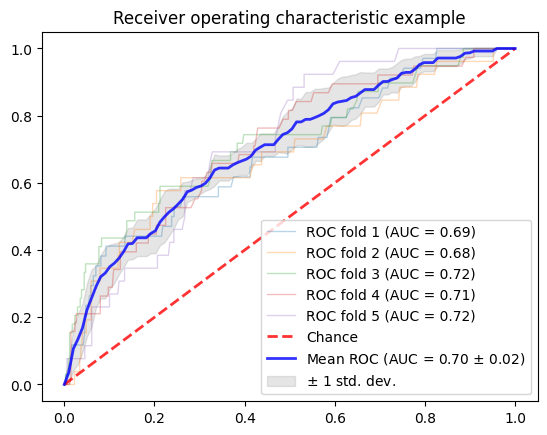

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.32075640770056896, 0.06707871461257528, 0.2726408642684144, 0.3805900752167208, 0.21493289706792984]
BEDROC: 0.251 +/- 0.107


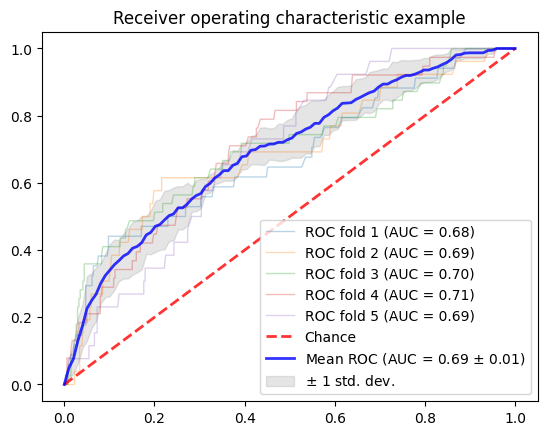

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.36036636173107056, 0.07343398885679263, 0.1928662505694944, 0.5088329711233311, 0.18636034210925598]
BEDROC: 0.264 +/- 0.153


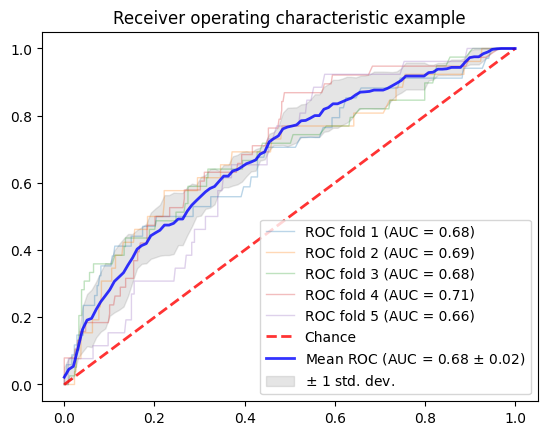

Best max_features: sqrt with BEDROC: 0.348


In [41]:
best_max_features, best_bedroc = find_best_max_features(X, y, max_features_list)

### combine the folds and train with best hyperparameter

In [42]:
#80% model, with best hyperparamter
X = subset1[morgan2_cols]
y = subset1.y_true_label
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)
model_1 = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(X,y)

In [43]:
#test with 20% test set
X = np.array(subset2[morgan2_cols])
y = np.array(subset2.y_true_label)

/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[(0.957, 0.0), (0.861, 0.0), (0.83, 1.0), (0.813, 0.0), (0.807, 0.0), (0.723, 1.0), (0.719, 0.0), (0.673, 1.0), (0.665, 1.0), (0.64, 0.0), (0.632, 0.0), (0.619, 0.0), (0.614, 0.0), (0.611, 0.0), (0.605, 0.0), (0.596, 0.0), (0.588, 1.0), (0.58, 0.0), (0.519, 1.0), (0.516, 0.0), (0.512, 0.0), (0.502, 0.0), (0.466, 0.0), (0.462, 0.0), (0.436, 0.0), (0.427, 0.0), (0.415, 0.0), (0.413, 0.0), (0.41, 0.0), (0.4, 0.0), (0.392, 0.0), (0.372, 0.0), (0.37, 0.0), (0.368, 0.0), (0.366, 1.0), (0.364, 0.0), (0.358, 0.0), (0.352, 0.0), (0.351, 0.0), (0.347, 1.0), (0.339, 0.0), (0.336, 0.0), (0.336, 1.0), (0.333, 0.0), (0.333, 0.0), (0.332, 0.0), (0.329, 0.0), (0.326, 0.0), (0.324, 0.0), (0.323, 0.0), (0.321, 0.0), (0.318, 0.0), (0.314, 0.0), (0.308, 0.0), (0.307, 1.0), (0.305, 0.0), (0.302, 0.0), (0.3, 1.0), (0.298, 0.0), (0.296, 0.0), (0.294, 1.0), (0.291, 0.0), (0.29, 0.0), (0.289, 0.0), (0.289, 0.0), (0.286, 0.0), (0.282, 0.0), (0.274, 0.0), (0.271, 0.0), (0.267, 0.0), (0.26, 0.0), (0.253, 0.0), (0

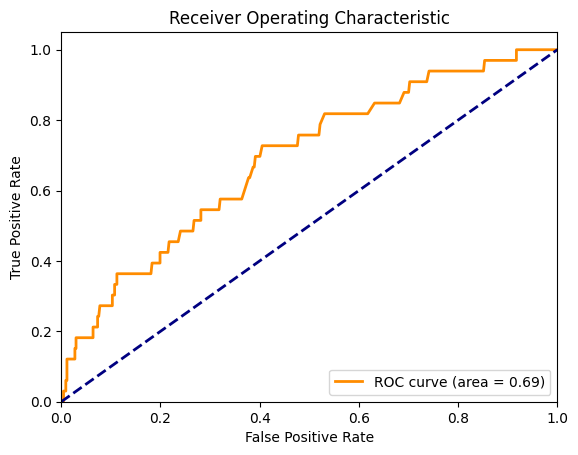

In [44]:
# Predict probabilities for the test data
y_scores = model_1.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
print(score)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [45]:
# combine train and test set and train the final model with full dataset
X = fullset[morgan2_cols]
y = fullset.y_true_label
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)

combined_model = RandomForestClassifier(n_estimators=1000, max_features=best_max_features, 
                                        min_samples_split=2, random_state=42).fit(np.array(X),np.array(y))
joblib.dump(combined_model, f'./trained_models/pubchem_morgan2_fullset.joblib')

['./trained_models/pubchem_morgan2_fullset.joblib']

## plot for tow models together

In [56]:

# plot the roc curve of the 20% pubchem test set on the two models trained with 80% training set
X = np.array(desc_cols2)
y = subset2.y_true_label

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_0.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(subset2[morgan2_cols])
y = subset2.y_true_label


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_1.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)


# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)


/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


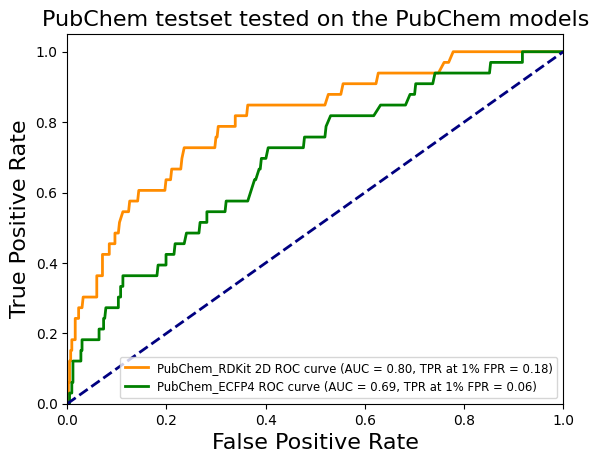

In [57]:
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)

# Update the labels to include the early ROC 1% value
label_model_1 = f'PubChem_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'PubChem_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('PubChem testset tested on the PubChem models', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

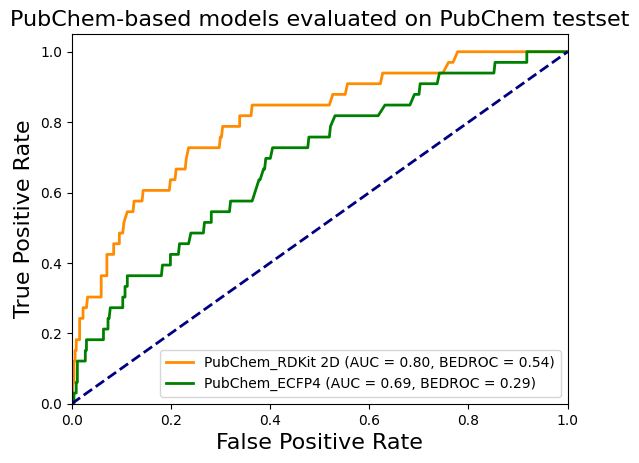

In [58]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'PubChem_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'PubChem_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('PubChem-based models evaluated on PubChem testset', fontsize=16)
plt.legend(loc="lower right")
plt.show()

## test pubchem models with chembl dataset

In [59]:
# test the full set models with external test set (full set chembl)
model_3 = joblib.load('./trained_models/pubchem_morgan2_fullset.joblib')
model_2 = joblib.load('./trained_models/pubchem_rdkit2D_fullset.joblib')

In [60]:
chembl_testset1 = pd.read_csv('./datasets/3_train_test_split/chembl_test_ECFP4_rdkit2d.csv')
chembl_testset2 = pd.read_csv('./datasets/3_train_test_split/chembl_train_ECFP4_rdkit2d.csv')

In [61]:
chembl_testset = pd.concat([chembl_testset1, chembl_testset2], ignore_index=True)

In [62]:
desc_cols4 = chembl_testset.iloc[:, 2055:2263]

### Ploting roc curves

In [63]:
X = np.array(desc_cols4)
y = chembl_testset.y_true_label

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_2.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)


# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(chembl_testset[morgan2_cols])
y = chembl_testset.y_true_label


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_3.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)

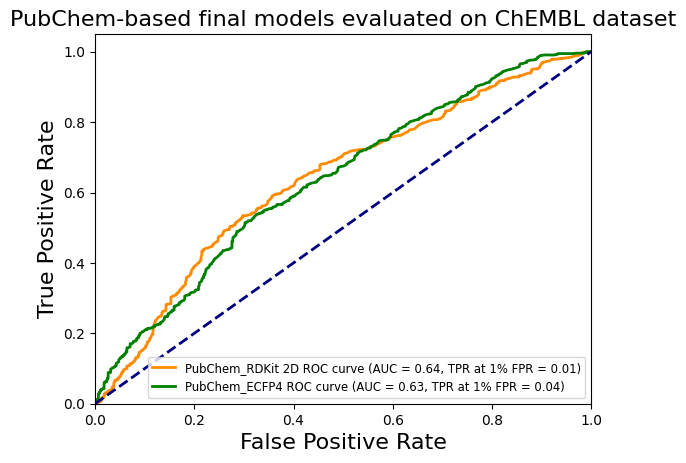

In [64]:
#early ROC version
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)
# Update the labels to include the early ROC 1% value
label_model_1 = f'PubChem_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'PubChem_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('PubChem-based final models evaluated on ChEMBL dataset', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

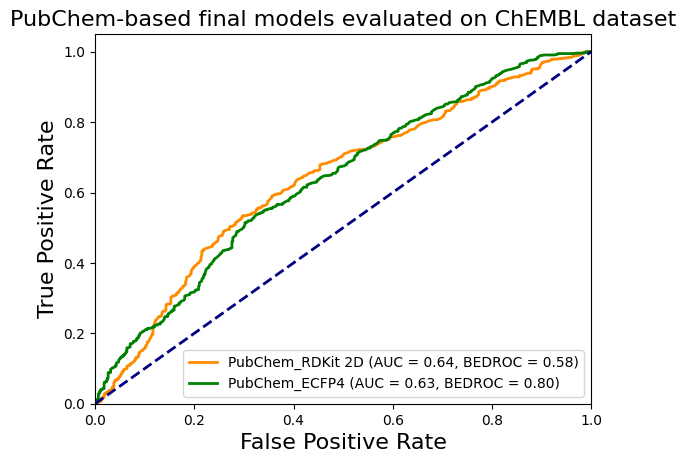

In [65]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'PubChem_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'PubChem_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('PubChem-based final models evaluated on ChEMBL dataset', fontsize=16)
plt.legend(loc="lower right")
plt.show()